# 1. Análise Exploratória dos Dados

## 1.1 Origem dos Dados
Os dados utilizados neste trabalho fazem parte do MovieLens, um sistema de recomendação de filmes mantido pelo GroupLens Research, da Universidade de Minnesota. O conjunto específico usado aqui é o MovieLens 32M (ml-32m), disponibilizado publicamente no site oficial:
http://grouplens.org/datasets/

Esse dataset reúne informações sobre filmes e avaliações feitas por usuários da plataforma ao longo de quase três décadas.

## 1.2 Arquivos Utilizados
Para este projeto, serão usados os arquivos:

movies.csv – contém informações dos filmes (ID, título e gêneros).
ratings.csv – contém avaliações feitas pelos usuários (ID do usuário, ID do filme, nota e timestamp).

Mesmo que existam outros arquivos como tags.csv e links.csv, eles não serão necessários para esta etapa da análise.

## 1.3 Tamanho do Dataset
O dataset completo é bastante grande, contendo:
32.000.204 avaliações
2.000.072 tags
87.585 filmes
200.948 usuários

Como usaremos apenas movies e ratings, o relevante para nossa análise é:
**movies.csv**
Aproximadamente 87.585 instâncias
3 atributos:
movieId
title
genres

**ratings.csv**
Aproximadamente 32 milhões de instâncias
4 atributos:
userId
movieId
rating
timestamp

## 1.4 Período Abrangido
O MovieLens 32M inclui avaliações registradas entre:

09 de janeiro de 1995
12 de outubro de 2023

Isso significa que o dataset cobre quase 30 anos de atividade de usuários.

## 1.5 Licença de Uso
O MovieLens é disponibilizado para uso acadêmico e de pesquisa, com algumas condições:

O dataset não pode ser utilizado para fins comerciais sem permissão.
É obrigatório citar a fonte em trabalhos que utilizem os dados.
Os dados podem ser redistribuídos, desde que sob as mesmas condições da licença original.
Não há garantias quanto à precisão dos dados.

## 1.6 Questões Éticas e de Privacidade
Mesmo sendo um dataset amplamente utilizado, é importante destacar algumas considerações éticas:

**O que foi anonimizado**
Os usuários não possuem nenhuma informação pessoal:
sem nome, idade, localização, gênero, profissão etc.

Cada usuário é identificado apenas por um número (userId), gerado especificamente para o dataset.

**Conteúdo sensível**
Não há conteúdo sensível explícito.
As avaliações são voluntárias e públicas para pesquisa.
O dataset é mantido por uma instituição acadêmica, seguindo boas práticas consolidadas.

**Por que é considerado eticamente aceitável**
Anonimização consistente.
Sem coleta de dados demográficos.
Uso permitido apenas para fins não comerciais.

# 2 Processamentos Realizados nos Dados
Nesta etapa, foram aplicadas diversas verificações e transformações para garantir a integridade e consistência dos dados utilizados.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter
import re

In [2]:
movies = pd.read_csv("../data/movies.csv")
ratings = pd.read_csv("../data/ratings.csv")

In [3]:
print("=== ANÁLISE BÁSICA DO DATASET ===")

print("\n1. PRIMEIRAS LINHAS DE CADA DATASET:")
print("\nMovies dataset:")
print(movies.head(3))
print("\nRatings dataset:")
print(ratings.head(3))

print("\n2. INFORMAÇÕES GERAIS:")
print("\nMovies - Shape:", movies.shape)
print("Ratings - Shape:", ratings.shape)

=== ANÁLISE BÁSICA DO DATASET ===

1. PRIMEIRAS LINHAS DE CADA DATASET:

Movies dataset:
   movieId                    title  \
0        1         Toy Story (1995)   
1        2           Jumanji (1995)   
2        3  Grumpier Old Men (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  

Ratings dataset:
   userId  movieId  rating  timestamp
0       1       17     4.0  944249077
1       1       25     1.0  944250228
2       1       29     2.0  943230976

2. INFORMAÇÕES GERAIS:

Movies - Shape: (87585, 3)
Ratings - Shape: (32000204, 4)


## 2.1 Verificação de dados faltantes

In [4]:
movies.isna().sum(), ratings.isna().sum()

(movieId    0
 title      0
 genres     0
 dtype: int64,
 userId       0
 movieId      0
 rating       0
 timestamp    0
 dtype: int64)

## 2.2 Verificação dos tipos de dados

In [5]:
movies.dtypes, ratings.dtypes

(movieId     int64
 title      object
 genres     object
 dtype: object,
 userId         int64
 movieId        int64
 rating       float64
 timestamp      int64
 dtype: object)

## 2.3 Verificação de Duplicatas

In [6]:
movies.duplicated(subset=["movieId"]).sum(), ratings.duplicated().sum()

(np.int64(0), np.int64(0))

## 2.4 Consistência interna
Valida se todos os movieId presentes em ratings.csv também existiem em movies.csv.

In [7]:
# Checar consistência de movieId entre ratings e movies
ids_movies = set(movies['movieId'])
ids_ratings = set(ratings['movieId'])

ids_invalidos = ids_ratings - ids_movies
len(ids_invalidos)

# Se > 0: existem avaliações de filmes que não estão no arquivo movies.

0

## 2.5 Análise de valores fora do domínio

In [8]:
values = sorted(ratings['rating'].unique())
values = [float(v) for v in values]
print(values)


[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


## 2.6 Análise de outliers

In [9]:
# Verifica distribuição de notas (para detectar outliers de comportamento)
ratings['rating'].value_counts().sort_index()

rating
0.5     525132
1.0     946675
1.5     531063
2.0    2028622
2.5    1685386
3.0    6054990
3.5    4290105
4.0    8367654
4.5    2974000
5.0    4596577
Name: count, dtype: int64

In [10]:
# Verifica usuários com muitos ratings (outliers)
ratings['userId'].value_counts().describe()

count    200948.000000
mean        159.246193
std         282.025462
min          20.000000
25%          36.000000
50%          73.000000
75%         167.000000
max       33332.000000
Name: count, dtype: float64

## 2.7 Amostragem para redução do conjunto

**Amostragem do ratings.csv**
Como o arquivo ratings.csv contém mais de 32 milhões de registros, foi realizada uma amostragem estratificada por usuário, preservando a distribuição real de avaliações.

Amostragem aplicada:
10% das avaliações de cada usuário.

Essa técnica evita vieses que poderiam surgir ao selecionar registros aleatórios globalmente ou ao limitar por quantidade de linhas.

In [11]:
sample_frac = 0.10
rng = np.random.default_rng(42)

def stratified_sample_ratings(path, sample_frac=0.10, chunksize=5_000_000):
    sampled_chunks = []
    reader = pd.read_csv(path, chunksize=chunksize)
    for chunk in reader:
        # aplicar amostragem por userId dentro do chunk
        sampled = (chunk.groupby('userId', group_keys=False)
                        .apply(lambda g: g.sample(frac=sample_frac, random_state=42)))
        sampled_chunks.append(sampled)
    sampled_df = pd.concat(sampled_chunks, ignore_index=True)
    return sampled_df

ratings_sample = stratified_sample_ratings("../data/ratings.csv", sample_frac=0.10)

C:\Users\laris\AppData\Local\Temp\ipykernel_24512\2775154040.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(frac=sample_frac, random_state=42)))
C:\Users\laris\AppData\Local\Temp\ipykernel_24512\2775154040.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(frac=sample_frac, random_state=42)))
C:\Users\laris\AppData\Local\Temp\ipykernel_24512\2775154040.py:10

In [12]:
print(f"Dataset original: {len(ratings):,} avaliações")
print(f"Dataset amostrado: {len(ratings_sample):,} avaliações")
print(f"Usuários originais: {ratings['userId'].nunique()}")
print(f"Usuários na amostra: {ratings_sample['userId'].nunique()}")

Dataset original: 32,000,204 avaliações
Dataset amostrado: 3,197,329 avaliações
Usuários originais: 200948
Usuários na amostra: 200948


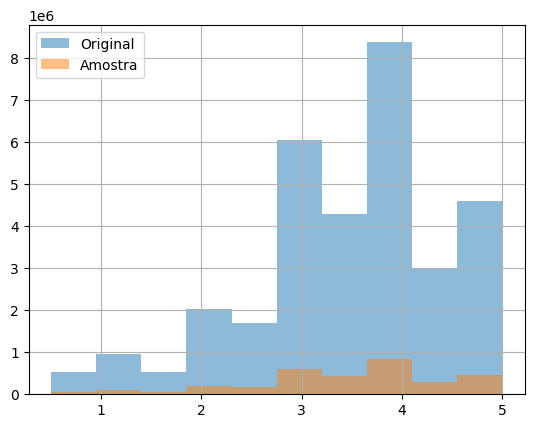

In [13]:
# Verificar se a amostragem preservou a distribuição
ratings['rating'].hist(bins=10, alpha=0.5, label='Original')
ratings_sample['rating'].hist(bins=10, alpha=0.5, label='Amostra')
plt.legend()
plt.show()

## 2.8 Feature engineering (atributos derivados importantes)

In [14]:
ratings = ratings_sample

# converter o timestamp para datetime antes de criar novas colunas
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

# tempo: ano e mes da avaliação
ratings['year'] = ratings['timestamp'].dt.year
ratings['month'] = ratings['timestamp'].dt.to_period('M').dt.to_timestamp()

# Agregados por filme
movie_stats = ratings.groupby('movieId')['rating'].agg(
    movie_rating_count='count',
    movie_rating_mean='mean',
    movie_rating_std='std'
).reset_index()

# agregados por usuário
user_stats = ratings.groupby('userId')['rating'].agg(
    user_rating_count='count',
    user_rating_mean='mean',
    user_rating_std='std'
).reset_index()

# juntar com movies
movies = movies.merge(movie_stats, on='movieId', how='left')

# extrair ano de lançamento do title, quando possível
def extract_year(title):
    m = re.search(r'\((\d{4})\)\s*$', str(title))
    if m:
        return int(m.group(1))
    else:
        return np.nan

movies['release_year'] = movies['title'].apply(extract_year)

# Explodir gêneros (uma linha por gênero) para agregações por gênero:
movies['genres_list'] = movies['genres'].str.split('|').apply(lambda x: x if isinstance(x, list) else [])
movies_exploded = movies.explode('genres_list').rename(columns={'genres_list':'genre'})

# 3. Estatísticas descritivas e distribuições

## 3.1 Estatísticas básicas (rating, counts)

In [15]:
# estatísticas descritivas principais
print("Ratings (global):")
print(ratings['rating'].describe())

print("\nMovie rating counts:")
print(movie_stats['movie_rating_count'].describe())

print("\nUser rating counts:")
print(user_stats['user_rating_count'].describe())

Ratings (global):
count    3.197329e+06
mean     3.543193e+00
std      1.059540e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

Movie rating counts:
count    42425.000000
mean        75.364266
std        373.455055
min          1.000000
25%          1.000000
50%          3.000000
75%         14.000000
max      17463.000000
Name: movie_rating_count, dtype: float64

User rating counts:
count    200948.000000
mean         15.911226
std          28.210490
min           2.000000
25%           4.000000
50%           7.000000
75%          17.000000
max        3333.000000
Name: user_rating_count, dtype: float64


## 3.2 Distribuição dos ratings (histograma)

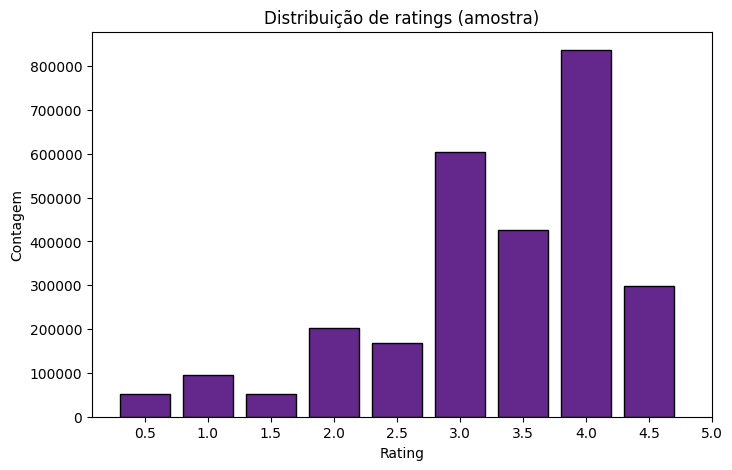

In [16]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,5))

bins = np.arange(0.25, 5.25, 0.5)

plt.hist(ratings['rating'], bins=bins, rwidth=0.8, edgecolor='black', color="#64278C")  # rwidth < 1 afasta as barras
plt.xlabel('Rating')
plt.ylabel('Contagem')
plt.title('Distribuição de ratings (amostra)')
plt.xticks(np.arange(0.5, 5.1, 0.5))  # marcações no eixo x a cada 0.5
plt.show()


## 3.3 Distribuição de avaliações por filme e por usuário (log-scale)

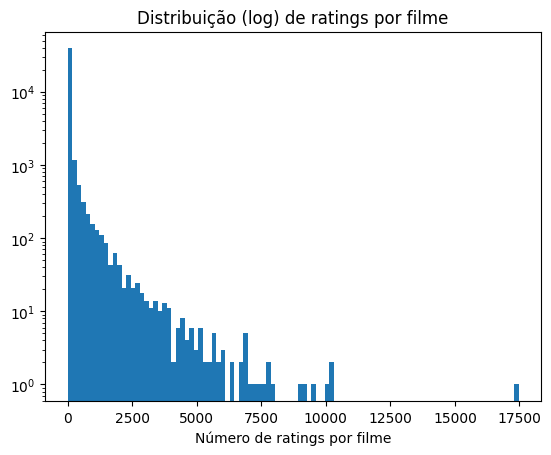

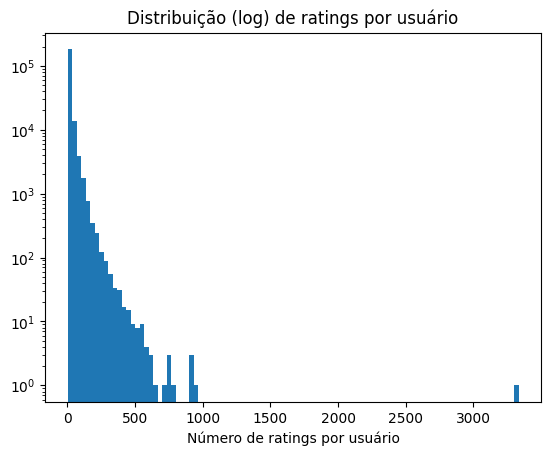

In [17]:
plt.figure()
plt.hist(movie_stats['movie_rating_count'].clip(1), bins=100, log=True)
plt.xlabel('Número de ratings por filme')
plt.title('Distribuição (log) de ratings por filme')
plt.show()

plt.figure()
plt.hist(user_stats['user_rating_count'].clip(1), bins=100, log=True)
plt.xlabel('Número de ratings por usuário')
plt.title('Distribuição (log) de ratings por usuário')
plt.show()

## 3.4 Análises por gênero

**Top gêneros por número de filmes e média de nota**

In [18]:
genre_counts = movies_exploded.groupby('genre')['movieId'].nunique().sort_values(ascending=False)
genre_rating = movies_exploded.groupby('genre')['movie_rating_mean'].mean().sort_values(ascending=False)

print(genre_counts.head(20))
print(genre_rating.head(20))

genre
Drama                 34175
Comedy                23124
Thriller              11823
Romance               10369
Action                 9668
Documentary            9363
Horror                 8654
(no genres listed)     7080
Crime                  6976
Adventure              5402
Sci-Fi                 4907
Animation              4617
Children               4520
Mystery                4013
Fantasy                3851
War                    2325
Western                1696
Musical                1059
Film-Noir               353
IMAX                    195
Name: movieId, dtype: int64
genre
Documentary           3.394321
Film-Noir             3.370826
War                   3.318601
IMAX                  3.232231
Drama                 3.225060
Musical               3.225051
Romance               3.168634
Animation             3.165777
Crime                 3.138928
Western               3.123227
Mystery               3.078011
Comedy                3.060502
(no genres listed)    3.0602

**Boxplot de ratings por gênero (só gêneros com N filmes mínimos)**

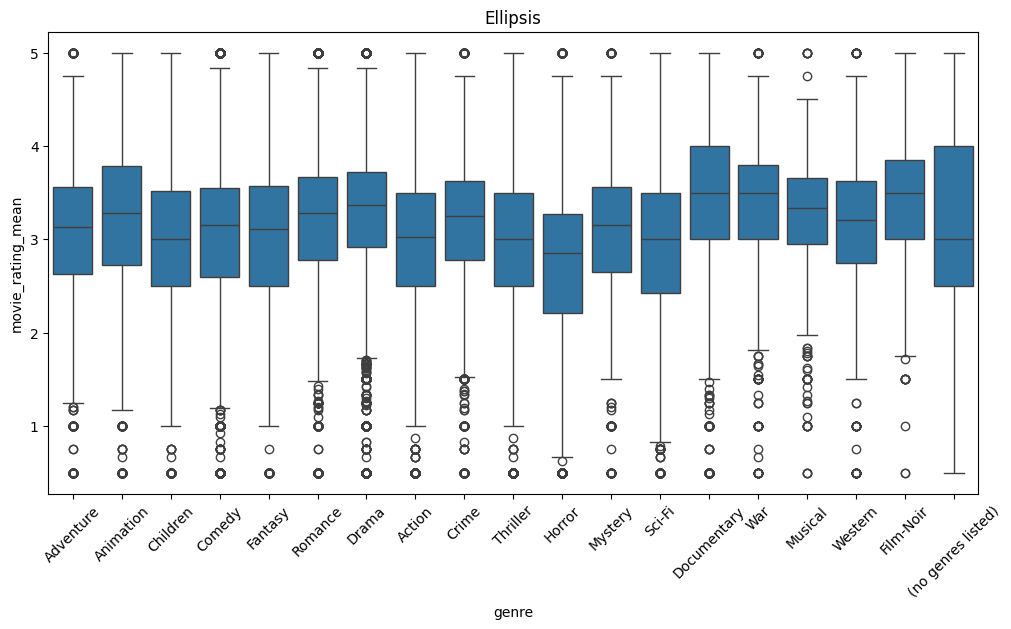

In [19]:
min_movies = 200  # filtrar gêneros com pelo menos 200 filmes para estabilidade
popular_genres = genre_counts[genre_counts >= min_movies].index.tolist()
df_plot = movies_exploded[movies_exploded['genre'].isin(popular_genres)].copy()

df_plot = df_plot.dropna(subset=['movie_rating_mean'])

# boxplot: cada ponto é um filme (média do filme)
plt.figure(figsize=(12,6))
sns.boxplot(x='genre', y='movie_rating_mean', data=df_plot)
plt.xticks(rotation=45)
plt.title(...)
plt.show()

## 3.5 Relações temporais (séries temporais)

**Evolução do número de ratings por ano/mês**

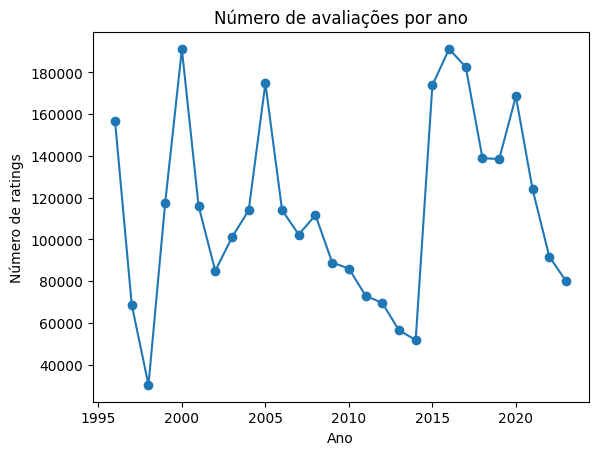

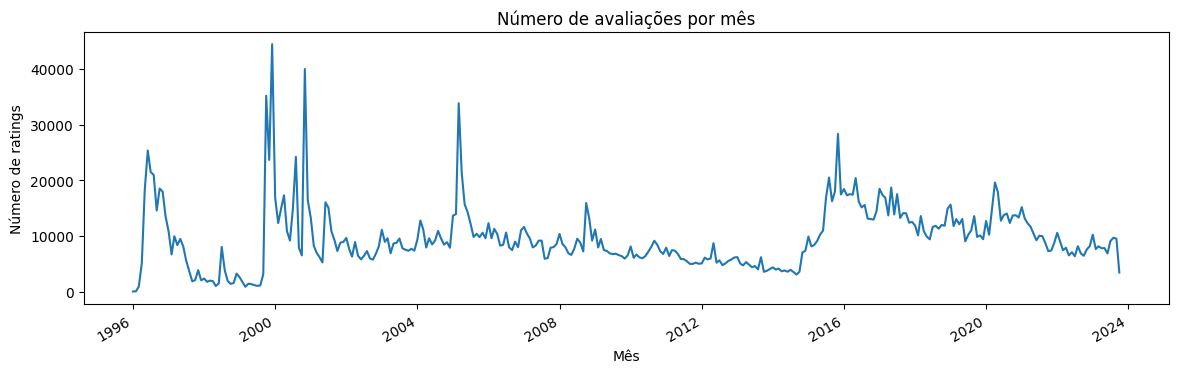

In [20]:
# ratings por ano
ratings_per_year = ratings.groupby('year').size()
ratings_per_month = ratings.groupby('month').size()

plt.figure()
ratings_per_year.plot(marker='o')
plt.xlabel('Ano')
plt.ylabel('Número de ratings')
plt.title('Número de avaliações por ano')
plt.show()

plt.figure(figsize=(14,4))
ratings_per_month.plot()
plt.xlabel('Mês')
plt.ylabel('Número de ratings')
plt.title('Número de avaliações por mês')
plt.show()

**Evolução da média de rating ao longo do tempo**

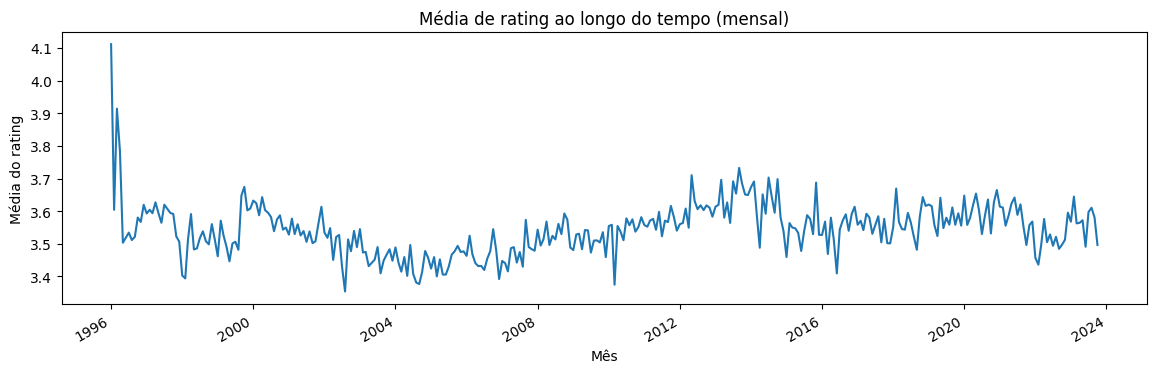

In [21]:
mean_rating_by_month = ratings.groupby('month')['rating'].mean()
plt.figure(figsize=(14,4))
mean_rating_by_month.plot()
plt.xlabel('Mês')
plt.ylabel('Média do rating')
plt.title('Média de rating ao longo do tempo (mensal)')
plt.show()

## 3.6 Correlações entre atributos derivados
Criamos um DataFrame com features numéricas e rodamos correlação (Pearson e Spearman):

Pearson:
                     movie_rating_mean  movie_rating_count  log_rating_count  \
movie_rating_mean            1.000000            0.102067          0.166179   
movie_rating_count           0.102067            1.000000          0.561063   
log_rating_count             0.166179            0.561063          1.000000   
release_year                -0.042638           -0.009930         -0.008452   

                    release_year  
movie_rating_mean      -0.042638  
movie_rating_count     -0.009930  
log_rating_count       -0.008452  
release_year            1.000000  

Spearman:
                     movie_rating_mean  movie_rating_count  log_rating_count  \
movie_rating_mean            1.000000            0.136611          0.136611   
movie_rating_count           0.136611            1.000000          1.000000   
log_rating_count             0.136611            1.000000          1.000000   
release_year                -0.041289           -0.101142         -0.101142   

           

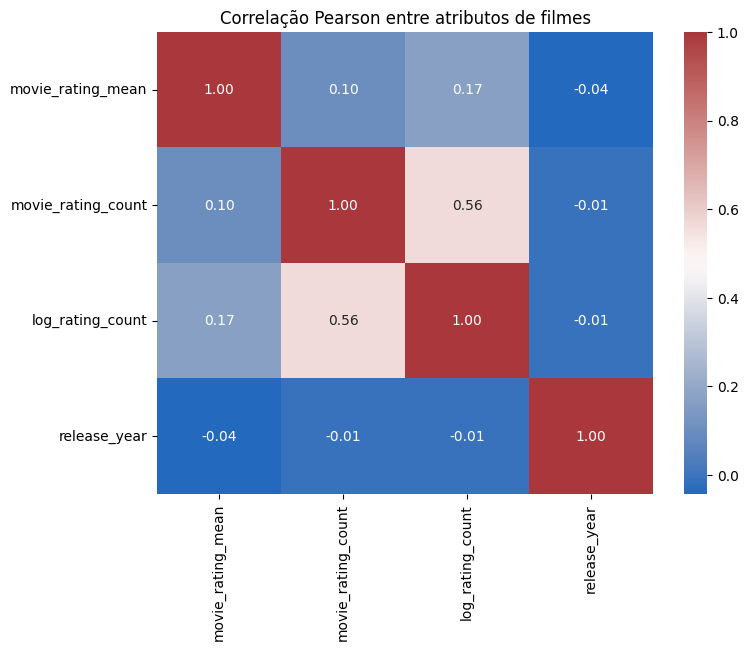

In [22]:
# construir features numéricas para correlação
# juntar stats de filme e usuario (exemplo por filme)
movie_corr_df = movies[['movieId', 'movie_rating_count', 'movie_rating_mean', 'release_year']].copy()

# adicionar popularidade relativa (log)
movie_corr_df['log_rating_count'] = np.log1p(movie_corr_df['movie_rating_count'])

# calcular correlações
corr_pearson = movie_corr_df[['movie_rating_mean','movie_rating_count','log_rating_count','release_year']].corr(method='pearson')
corr_spearman = movie_corr_df[['movie_rating_mean','movie_rating_count','log_rating_count','release_year']].corr(method='spearman')

print("Pearson:\n", corr_pearson)
print("\nSpearman:\n", corr_spearman)

# heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_pearson, annot=True, fmt=".2f", cmap='vlag')
plt.title('Correlação Pearson entre atributos de filmes')
plt.show()

## 3.7 Relações entre popularidade e avaliação (scatter)

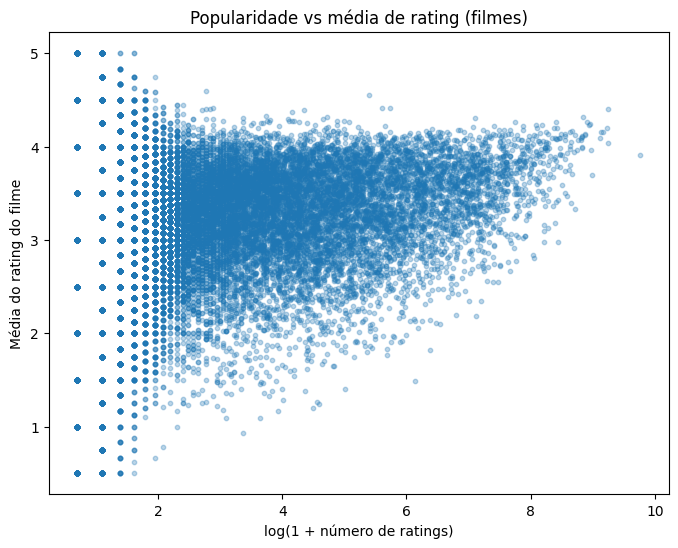

In [23]:
plt.figure(figsize=(8,6))
plt.scatter(movie_corr_df['log_rating_count'], movie_corr_df['movie_rating_mean'], alpha=0.3, s=10)
plt.xlabel('log(1 + número de ratings)')
plt.ylabel('Média do rating do filme')
plt.title('Popularidade vs média de rating (filmes)')
plt.show()


## 3.8 Verificações finais de qualidade (checklist automatizado)

In [24]:
def quality_checks(movies, ratings):
    checks = {}
    checks['movies_nulls'] = movies.isnull().sum()
    checks['ratings_nulls'] = ratings.isnull().sum()
    checks['movieId_in_ratings_not_in_movies'] = len(set(ratings['movieId']) - set(movies['movieId']))
    checks['rating_min_max'] = (ratings['rating'].min(), ratings['rating'].max())
    checks['unique_users'] = ratings['userId'].nunique()
    checks['unique_movies'] = ratings['movieId'].nunique()
    return checks

qc = quality_checks(movies, ratings)
qc

{'movies_nulls': movieId                   0
 title                     0
 genres                    0
 movie_rating_count    45160
 movie_rating_mean     45160
 movie_rating_std      60333
 release_year            617
 genres_list               0
 dtype: int64,
 'ratings_nulls': userId       0
 movieId      0
 rating       0
 timestamp    0
 year         0
 month        0
 dtype: int64,
 'movieId_in_ratings_not_in_movies': 0,
 'rating_min_max': (np.float64(0.5), np.float64(5.0)),
 'unique_users': 200948,
 'unique_movies': 42425}

4. PERGUNTAS

Pergunta 1 — Quais são os filmes mais bem avaliados?

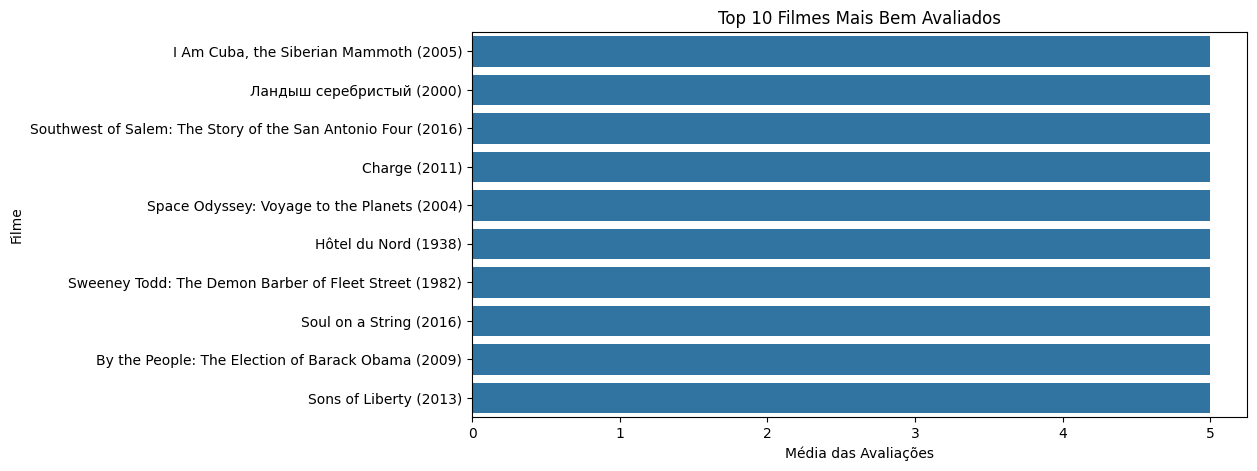

In [25]:
# Juntar ratings com títulos dos filmes
ratings_with_titles = ratings.merge(movies[['movieId', 'title']], on='movieId', how='left')

media_por_filme = (
    ratings_with_titles.groupby("title")["rating"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

top10 = media_por_filme.head(10)

plt.figure(figsize=(10,5))
sns.barplot(data=top10, x="rating", y="title")
plt.title("Top 10 Filmes Mais Bem Avaliados")
plt.xlabel("Média das Avaliações")
plt.ylabel("Filme")
plt.show()

Pergunta 2 — Quais filmes têm mais avaliações (populares)?

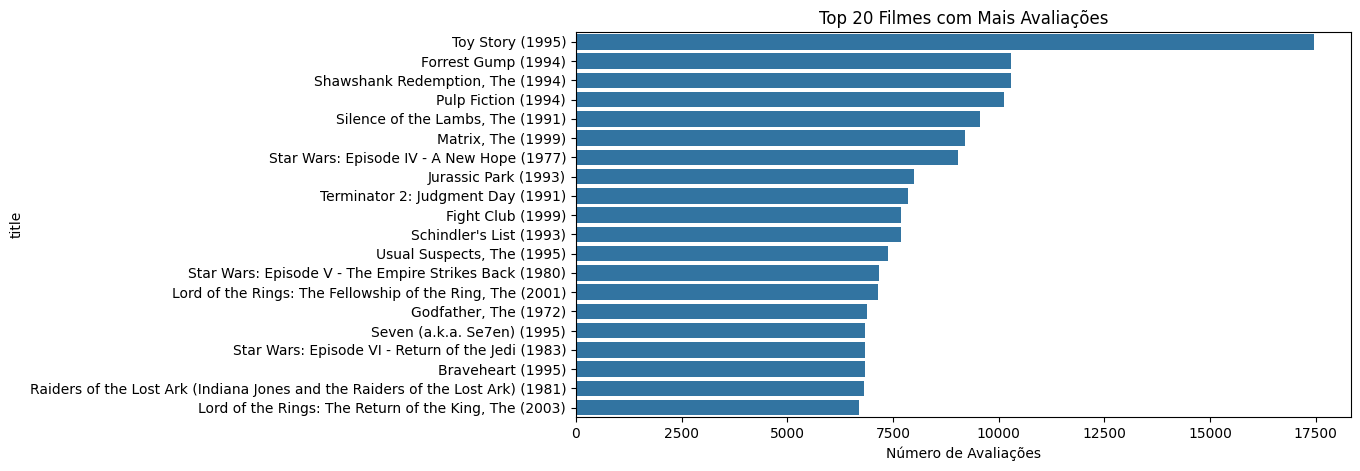

In [26]:
popularidade = ratings_with_titles["title"].value_counts().head(20)

plt.figure(figsize=(10,5))
sns.barplot(x=popularidade.values, y=popularidade.index)
plt.title("Top 20 Filmes com Mais Avaliações")
plt.xlabel("Número de Avaliações")
plt.show()

Pergunta 3 — Distribuição das Notas por Ano

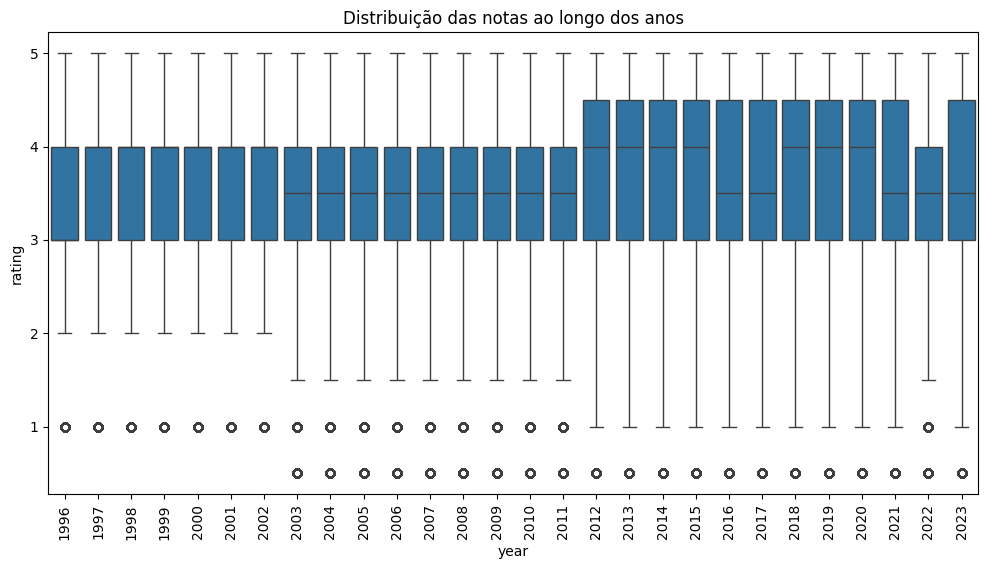

In [27]:
plt.figure(figsize=(12,6))
sns.boxplot(data=ratings, x="year", y="rating")
plt.xticks(rotation=90)
plt.title("Distribuição das notas ao longo dos anos")
plt.show()

Pergunta 4 — Quais gêneros são mais populares?

In [28]:
from collections import Counter

# contar cada gênero corretamente
todos_generos = Counter(movies_exploded["genre"])

# transformar em DataFrame
generos_df = (
    pd.DataFrame.from_dict(todos_generos, orient="index", columns=["count"])
      .sort_values("count", ascending=False)
)

print(generos_df)

                    count
Drama               34175
Comedy              23124
Thriller            11823
Romance             10369
Action               9668
Documentary          9363
Horror               8654
(no genres listed)   7080
Crime                6976
Adventure            5402
Sci-Fi               4907
Animation            4617
Children             4520
Mystery              4013
Fantasy              3851
War                  2325
Western              1696
Musical              1059
Film-Noir             353
IMAX                  195


Pergunta 5 - Padrão de avaliação dos usuários (alguém é mais crítico?)

Usuários Mais Críticos (menor nota média):
        userId  user_rating_count  user_rating_mean  user_rating_std
15475    15476                 29          0.500000         0.000000
8119      8120                 26          0.711538         0.550873
168189  168190                 35          0.728571         0.770245
27568    27569                 24          0.854167         1.202164
140127  140128                 23          0.869565         0.457697
114496  114497                 87          0.908046         0.756863
181611  181612                 58          0.956897         0.696385
148731  148732                 88          0.971591         0.716625
107407  107408                 20          0.975000         1.175126
179711  179712                124          0.975806         1.260492

Usuários Mais Generosos (maior nota média):
       userId  user_rating_count  user_rating_mean  user_rating_std
2016     2017                 23               5.0              0.0
2766     2767    

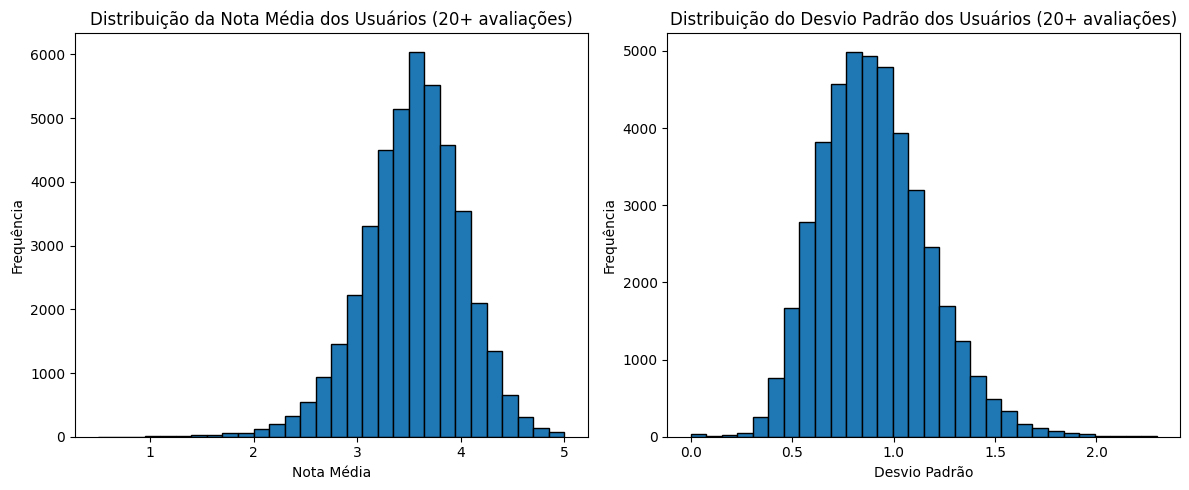

In [31]:
# Selecionar apenas usuários com pelo menos 20 avaliações
user_stats_filtered = user_stats[user_stats['user_rating_count'] >= 20].copy()

print("Usuários Mais Críticos (menor nota média):")
print(user_stats_filtered.nsmallest(10, 'user_rating_mean'))

print("\nUsuários Mais Generosos (maior nota média):")
print(user_stats_filtered.nlargest(10, 'user_rating_mean'))

print("\nUsuários Mais Consistentes (menor desvio padrão):")
print(user_stats_filtered.nsmallest(10, 'user_rating_std'))

plt.figure(figsize=(12,5))

# Distribuição das médias dos usuários
plt.subplot(1,2,1)
plt.hist(user_stats_filtered['user_rating_mean'], bins=30, edgecolor='black')
plt.title("Distribuição da Nota Média dos Usuários (20+ avaliações)")
plt.xlabel("Nota Média")
plt.ylabel("Frequência")

# Distribuição do desvio padrão dos usuários
plt.subplot(1,2,2)
plt.hist(user_stats_filtered['user_rating_std'], bins=30, edgecolor='black')
plt.title("Distribuição do Desvio Padrão dos Usuários (20+ avaliações)")
plt.xlabel("Desvio Padrão")
plt.ylabel("Frequência")

plt.tight_layout()
plt.show()

Pergunta 6 - Qual é a nota mais comum (moda) para cada filme?

Exemplos de Filmes e suas Modas:
                                             title      mean  moda  count
0                                           (2019)  2.833333   3.0      3
1                 "Great Performances" Cats (1998)  2.809524   0.5     21
2                                     "Sr." (2022)  4.000000   4.0      1
3                       #1 Cheerleader Camp (2010)  4.000000   4.0      1
4                                    #Alive (2020)  3.200000   3.5     15
5              #AnneFrank. Parallel Stories (2019)  3.500000   3.5      1
6                          #Female Pleasure (2018)  3.500000   3.5      1
7                         #FriendButMarried (2018)  0.500000   0.5      1
8                                   #Horror (2015)  1.833333   1.0      3
9                          #cats_the_mewvie (2020)  2.166667   0.5      3
10                             #realityhigh (2017)  3.700000   3.5      5
11                              $ (Dollars) (1971)  4.500000   4.5      1
12   

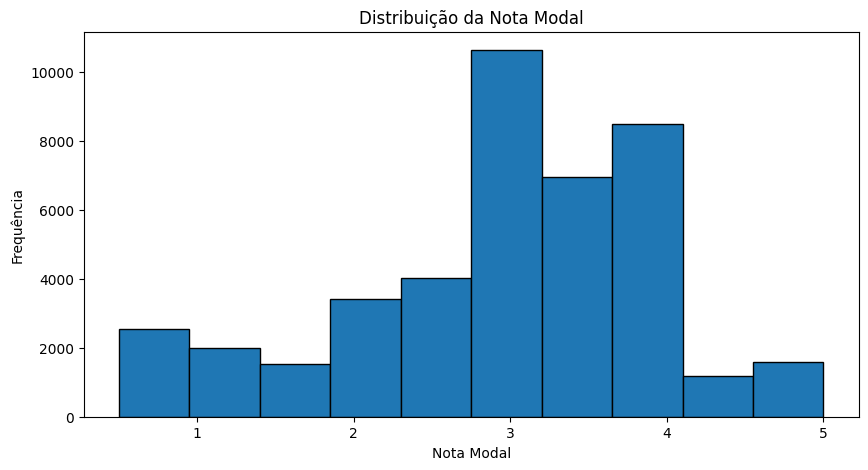

In [ ]:
filme_stats = ratings_with_titles.groupby('title')['rating'].agg(['mean', 'std', 'count']).reset_index()

from scipy import stats

filme_moda = (
    ratings_with_titles
    .groupby('title')['rating']
    .apply(lambda x: stats.mode(x, keepdims=True).mode[0])
    .reset_index()
)
filme_moda.columns = ['title', 'moda']

filme_stats_moda = filme_stats.merge(filme_moda, on='title', how='left')

print("Exemplos de Filmes e suas Modas:")
print(filme_stats_moda[['title', 'mean', 'moda', 'count']].head(20))

plt.figure(figsize=(10,5))
plt.hist(filme_moda['moda'].dropna(), bins=10, edgecolor='black')
plt.title("Distribuição da Nota Modal")
plt.xlabel("Nota Modal")
plt.ylabel("Frequência")
plt.show()

Pergunta 7 — Filmes com mais gêneros têm notas diferentes?

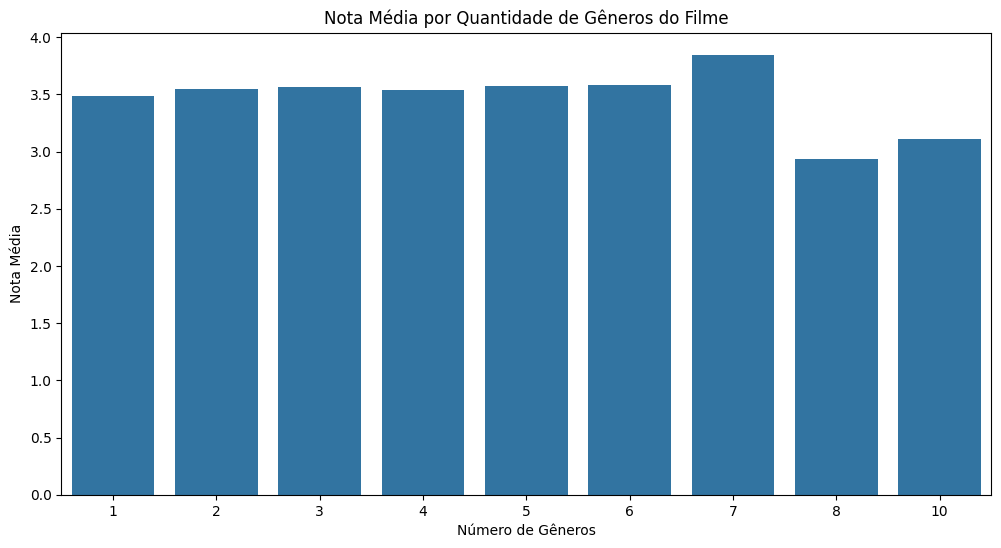

In [ ]:
movies['num_genres'] = movies['genres_list'].apply(len)

ratings_genres = ratings.merge(movies[['movieId', 'num_genres']], on='movieId', how='left')

media_por_num_generos = (
    ratings_genres.groupby('num_genres')['rating']
    .agg(['mean', 'std', 'count'])
    .reset_index()
)

plt.figure(figsize=(12,6))
sns.barplot(data=media_por_num_generos, x='num_genres', y='mean')
plt.title("Nota Média por Quantidade de Gêneros do Filme")
plt.xlabel("Número de Gêneros")
plt.ylabel("Nota Média")
plt.show()


Pergunta 8 — Qual é o filme mais unanimemente bom?

                                                   title      mean       std  \
12747                       Foreign Correspondent (1940)  3.803571  0.623696   
41393     Winged Migration (Peuple migrateur, Le) (2001)  4.045455  0.640415   
21513                      Magdalene Sisters, The (2002)  3.880531  0.641825   
21956  Maria Full of Grace (Maria, Llena eres de grac...  3.824701  0.656618   
30451                             Shattered Glass (2003)  3.656000  0.658125   
26037                                  Paper Moon (1973)  3.970588  0.659534   
26871                          Play It Again, Sam (1972)  3.922481  0.659811   
24861                          Notes on a Scandal (2006)  3.732353  0.662039   
10914                               Eight Men Out (1988)  3.746512  0.666049   
36290                                The Night Of (2016)  4.201835  0.667081   
17291             Infernal Affairs (Mou gaan dou) (2002)  3.998288  0.667737   
8537                                    

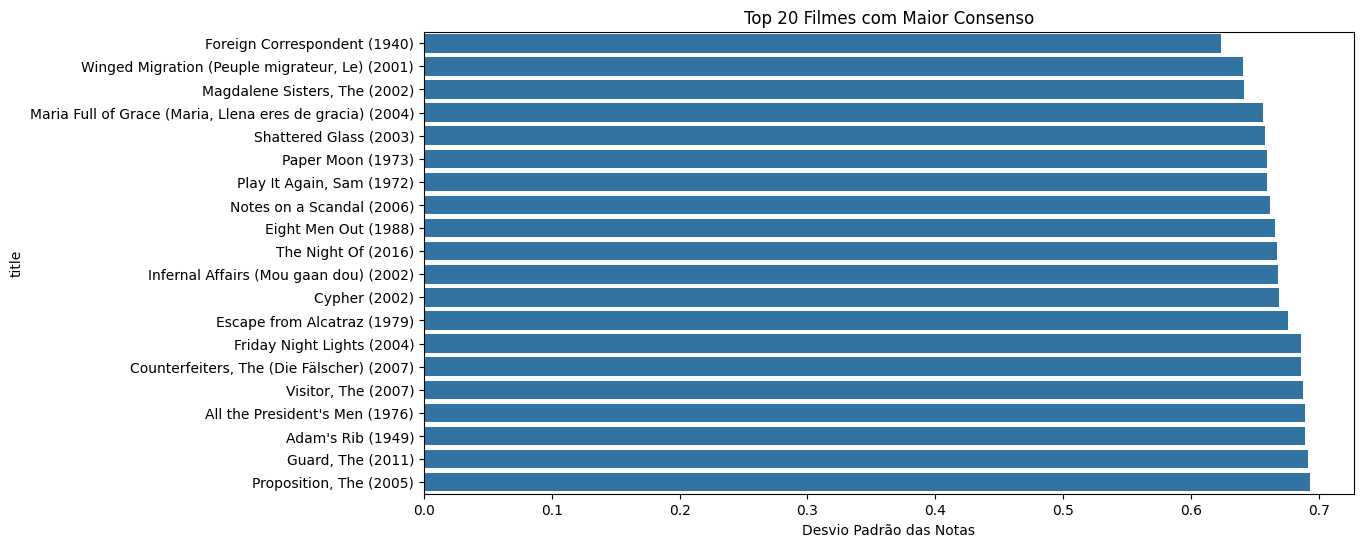

In [ ]:
# Filmes com consenso (baixa variabilidade + nota alta + muitas avaliações)
filme_stats_consenso = filme_stats[filme_stats['count'] >= 100].copy()
filme_stats_consenso = filme_stats_consenso.sort_values('std', ascending=True)

print(filme_stats_consenso[filme_stats_consenso['mean'] >= 3.5].head(20))

plt.figure(figsize=(12,6))
sns.barplot(
    data=filme_stats_consenso[filme_stats_consenso['mean'] >= 3.5].head(20),
    x='std', y='title'
)
plt.title("Top 20 Filmes com Maior Consenso")
plt.xlabel("Desvio Padrão das Notas")
plt.show()


Pergunta 9 — Qual gênero é mais "divisivo" (maior variabilidade)?

                                                   title      mean       std  \
12196                         Fifty Shades Darker (2017)  2.610000  1.588511   
7378                               Civil War, The (1990)  3.800000  1.529343   
14901                   Hannah Montana: The Movie (2009)  2.862903  1.512704   
29061                                   Room, The (2003)  2.197802  1.497923   
14826                                    Hamilton (2020)  3.687831  1.470602   
35618                           The Kissing Booth (2018)  2.589286  1.468169   
7042       Children of the Corn IV: The Gathering (1996)  2.547170  1.461454   
26974                        Pokémon 3: The Movie (2001)  1.856061  1.453815   
26830                     Plan 9 from Outer Space (1959)  2.555970  1.448440   
39221  Twilight Saga: Breaking Dawn - Part 2, The (2012)  2.611872  1.447885   
30151               Serbian Film, A (Srpski film) (2010)  2.756410  1.447666   
39220  Twilight Saga: Breaking Dawn - Pa

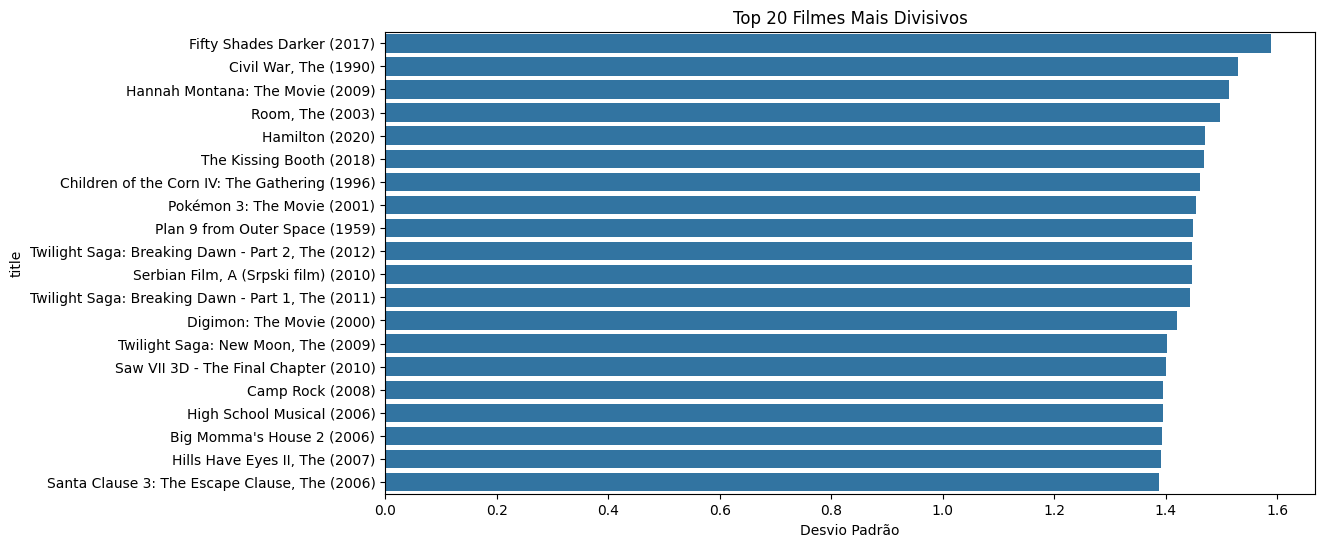

In [ ]:
filme_stats2 = (
    ratings_with_titles.groupby('title')['rating']
    .agg(['mean', 'std', 'count'])
    .reset_index()
)

filme_stats2 = filme_stats2[filme_stats2['count'] >= 50]
filme_stats2 = filme_stats2.sort_values('std', ascending=False)

print(filme_stats2.head(20))

plt.figure(figsize=(12,6))
sns.barplot(data=filme_stats2.head(20), x='std', y='title')
plt.title("Top 20 Filmes Mais Divisivos")
plt.xlabel("Desvio Padrão")
plt.show()


Pergunta 10 — Qual gênero tem a maior nota média?

                        mean    count       std
genre                                          
Film-Noir           3.919978    30073  0.909425
War                 3.796751   158980  0.986112
Crime               3.696270   536069  1.007124
Documentary         3.683321    42382  1.029976
Drama               3.683224  1388744  0.996928
Mystery             3.677328   259888  1.004054
Animation           3.631703   231240  1.036242
Western             3.603925    60823  1.013409
IMAX                3.598433   144977  1.056412
Musical             3.550083   117875  1.057112
Romance             3.545618   549681  1.048782
Thriller            3.533367   865904  1.036850
Adventure           3.530827   766449  1.068578
Fantasy             3.522774   378965  1.088873
Sci-Fi              3.494336   570070  1.083758
Action              3.478298   962561  1.070241
Children            3.456408   284813  1.096432
Comedy              3.437945  1125250  1.082823
(no genres listed)  3.385861     5467  1

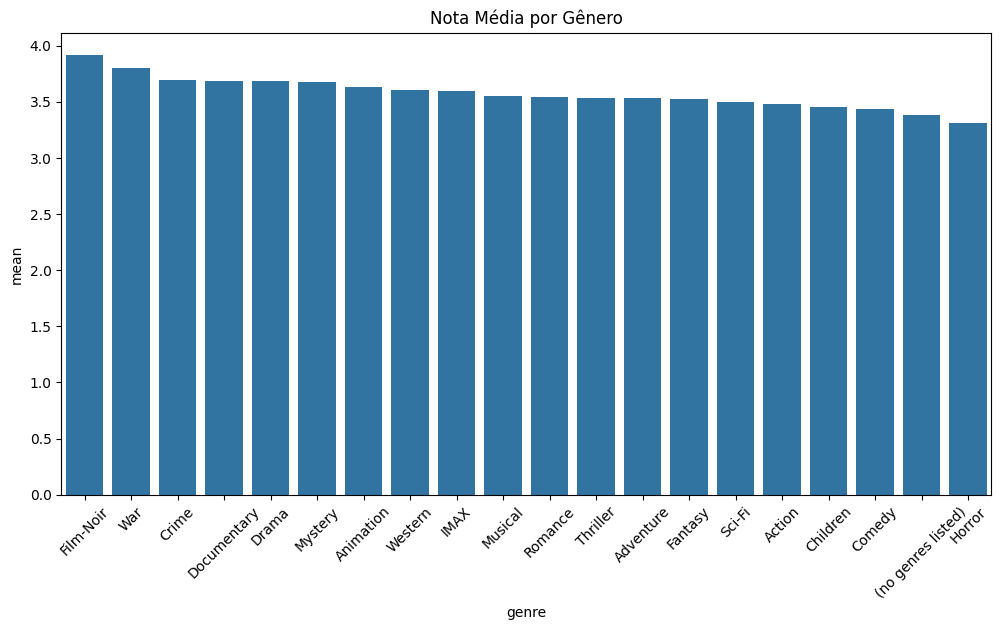

In [ ]:
df_generos = ratings_with_titles.merge(
    movies_exploded[['movieId', 'genre']],
    on='movieId', how='left'
)

media_generos = (
    df_generos.groupby('genre')['rating']
    .agg(['mean', 'count', 'std'])
    .sort_values('mean', ascending=False)
)

print(media_generos)

plt.figure(figsize=(12,6))
sns.barplot(data=media_generos.reset_index(), x='genre', y='mean')
plt.xticks(rotation=45)
plt.title("Nota Média por Gênero")
plt.show()


Pergunta 11 — Correlação entre gêneros (quais gêneros aparecem juntos nos melhores filmes?)

(Action, Drama)           60
(Action, Adventure)       56
(Drama, Thriller)         55
(Drama, Romance)          55
(Adventure, Drama)        54
(Comedy, Drama)           50
(Comedy, Romance)         45
(Crime, Drama)            45
(Drama, Fantasy)          44
(Action, Comedy)          42
(Adventure, Fantasy)      41
(Action, Thriller)        41
(Adventure, Animation)    39
(Action, Sci-Fi)          38
(Crime, Thriller)         38
Name: count, dtype: int64


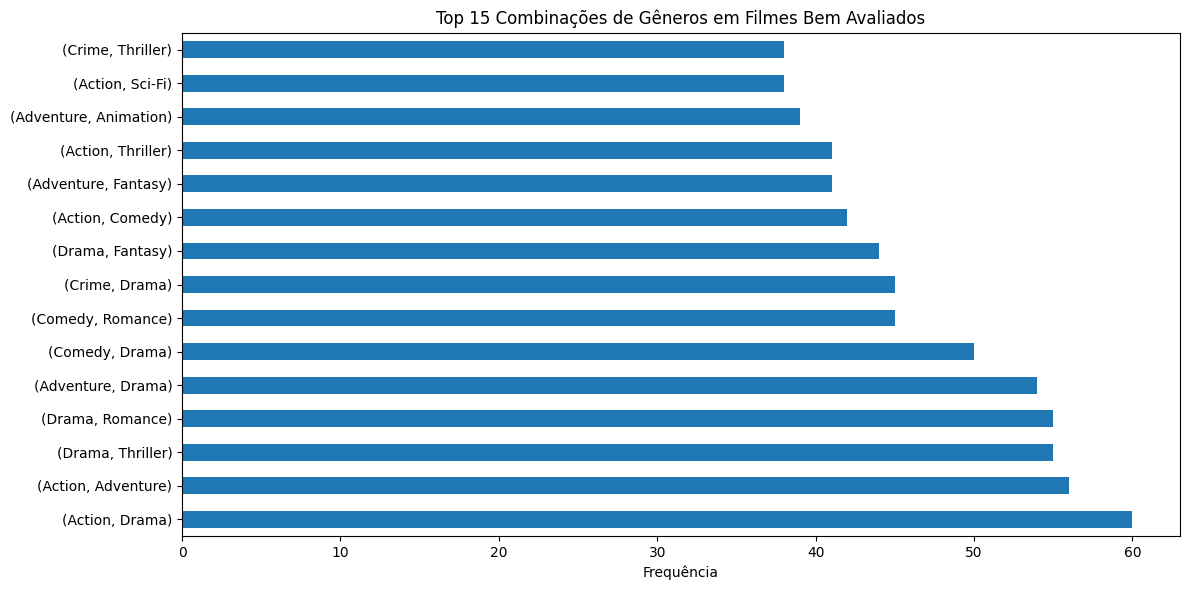

In [ ]:
from itertools import combinations

df_top_rated = ratings_with_titles.merge(
    movies[['movieId','genres']], on='movieId'
)

df_top_rated = df_top_rated[df_top_rated.groupby('title')['rating'].transform('mean') >= 4.0]

genre_pairs = []
for g in df_top_rated['genres'].dropna().unique():
    genres = g.split('|')
    if len(genres) > 1:
        for pair in combinations(sorted(genres), 2):
            genre_pairs.append(pair)

genre_pairs_count = pd.Series(genre_pairs).value_counts().head(15)

print(genre_pairs_count)

plt.figure(figsize=(12,6))
genre_pairs_count.plot(kind='barh')
plt.title("Top 15 Combinações de Gêneros em Filmes Bem Avaliados")
plt.xlabel("Frequência")
plt.tight_layout()
plt.show()


Pergunta 12 — Filmes mais bem avaliados por ano

In [ ]:
ratings_with_titles['year_release'] = movies['release_year']

filme_por_ano = (
    ratings_with_titles.groupby(['year_release', 'title'])['rating']
    .agg(['mean', 'count'])
    .reset_index()
)

filme_por_ano = filme_por_ano[filme_por_ano['count'] >= 10]

melhor_filme_por_ano = (
    filme_por_ano.loc[filme_por_ano.groupby('year_release')['mean'].idxmax()]
    .sort_values('year_release')
)

print(melhor_filme_por_ano[['year_release', 'title', 'mean', 'count']].tail(20))

# Plot
# Plot
plt.figure(figsize=(16,7))

# remove NaN e filtra entre 1980 e 2024
valid = melhor_filme_por_ano.dropna(subset=['year_release'])
valid = valid[(valid['year_release'] >= 1980) & (valid['year_release'] <= 2024)]

ax = plt.gca()
bars = ax.bar(valid['year_release'], valid['mean'], width=0.8, alpha=0.7,
              edgecolor='black')

ax.plot(valid['year_release'], valid['mean'], linewidth=2, marker='o')

plt.title("Nota do Melhor Filme por Ano")
plt.xlabel("Ano")
plt.ylabel("Nota Média")
plt.xticks(rotation=45)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


KeyError: 'release_year'

Melhor Filme por Ano:
       year_release                                              title  \
12826        2004.0                               Riding Giants (2004)   
13261        2005.0               Joyeux Noël (Merry Christmas) (2005)   
14032        2006.0                                Planet Earth (2006)   
14580        2007.0                   In the Shadow of the Moon (2007)   
15262        2008.0   House of Small Cubes, The (Tsumiki no ie) (2008)   
15998        2009.0                                        Home (2009)   
16750        2010.0                                   Inception (2010)   
17212        2011.0  All Watched Over by Machines of Loving Grace (...   
18399        2012.0                                    Paperman (2012)   
18845        2013.0  Dance of Reality, The (Danza de la realidad, L...   
19767        2014.0                               Force Majeure (2014)   
21094        2015.0                       The Boy and the Beast (2015)   
21811        201

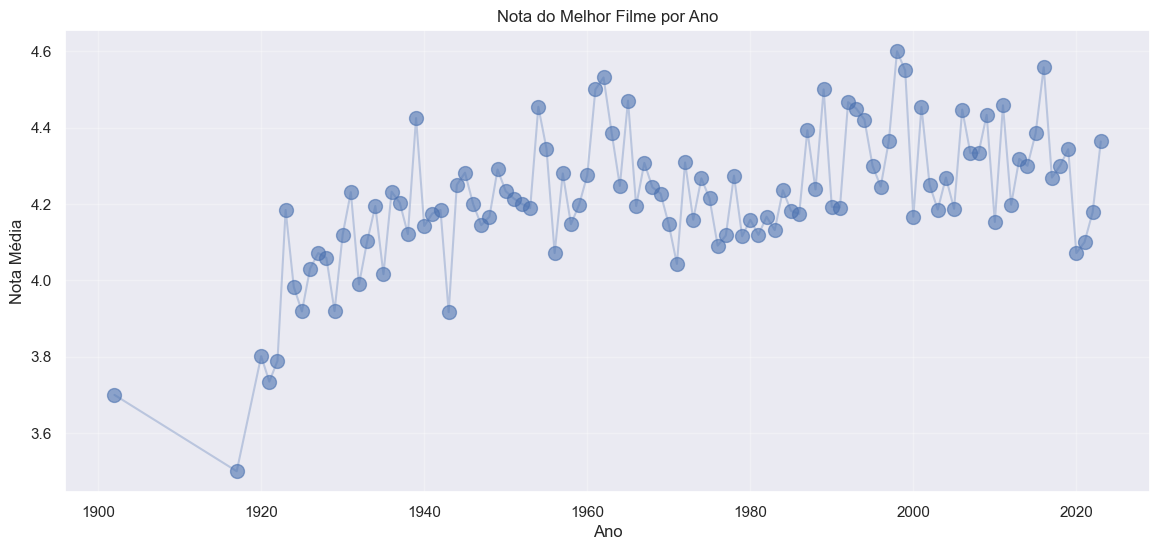

In [ ]:
# Encontrar o melhor filme de cada ano (com mínimo de avaliações)
df['year_release'] = df['title'].str.extract(r'\((\d{4})\)$')
df['year_release'] = pd.to_numeric(df['year_release'], errors='coerce')

filme_por_ano = df.groupby(['year_release', 'title'])['rating'].agg(['mean', 'count']).reset_index()
filme_por_ano = filme_por_ano[filme_por_ano['count'] >= 10]  # Mínimo de 10 avaliações

# Top filme por ano
melhor_filme_por_ano = filme_por_ano.loc[filme_por_ano.groupby('year_release')['mean'].idxmax()]
melhor_filme_por_ano = melhor_filme_por_ano.sort_values('year_release')

print("Melhor Filme por Ano:")
print(melhor_filme_por_ano[['year_release', 'title', 'mean', 'count']].tail(20))

# Gráfico com barras mostrando a nota do melhor filme por ano
plt.figure(figsize=(16,7))

# Filtrar apenas anos com dados válidos
melhor_por_ano_valid = melhor_filme_por_ano.dropna(subset=['year_release'])
melhor_por_ano_valid = melhor_por_ano_valid[melhor_por_ano_valid['year_release'] >= 1980]

# Gráfico de barras com linha de tendência
ax = plt.gca()
bars = ax.bar(melhor_por_ano_valid['year_release'], melhor_por_ano_valid['mean'], 
              width=0.8, alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)

# Linha de tendência
ax.plot(melhor_por_ano_valid['year_release'], melhor_por_ano_valid['mean'], 
        color='red', linewidth=2, marker='o', markersize=6, alpha=0.8, label='Tendência')

# Adicionar valores nas barras
for i, (year, rating) in enumerate(zip(melhor_por_ano_valid['year_release'], melhor_por_ano_valid['mean'])):
    ax.text(year, rating + 0.05, f'{rating:.2f}', ha='center', va='bottom', fontsize=8)

plt.title("Nota do Melhor Filme por Ano", fontsize=14, fontweight='bold')
plt.xlabel("Ano de Lançamento", fontsize=12)
plt.ylabel("Nota Média do Melhor Filme", fontsize=12)
plt.ylim(0, 5.5)
plt.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()